# Comparing to original code
Adapted from code by [bmachiel](https://github.com/bmachiel/python-nport/blob/master/nport/eigenshuffle.py), which in turn was based on matlab [eigenshuffle](http://www.mathworks.com/matlabcentral/fileexchange/22885).  
`eigenshuffle_original` was slightly modified to be able to run on python 3.

In [1]:
import numpy as np
import munkres
import matplotlib.pyplot as plt
import numpy.typing as npt

from eigenshuffle import eigenshuffle_eig

plt.rcParams["font.size"] = 13

In [2]:
def eigenshuffle_original(Asequence):
    Ashape = np.shape(Asequence)
    if Ashape[-1] != Ashape[-2]:
        raise Exception(
            "Asequence must be a (nxpxp) array of " "eigen-problems, each of size pxp"
        )
    p = Ashape[-1]
    if len(Ashape) < 3:
        n = 1
        Asequence = np.asarray([Asequence], dtype=complex)
    else:
        n = Ashape[0]

    Vseq = np.zeros((n, p, p), dtype=complex)
    Dseq = np.zeros((n, p), dtype=complex)

    for i in range(n):
        D, V = np.linalg.eig(Asequence[i])
        # initial ordering is purely in decreasing order.
        # If any are complex, the sort is in terms of the
        # real part.
        tags = np.argsort(D.real, axis=0)

        Dseq[i] = D[tags]
        Vseq[i] = V[:, tags]

    def distancematrix(vec1, vec2):
        """simple interpoint distance matrix"""
        v1, v2 = np.meshgrid(vec1, vec2)
        return np.abs(v1 - v2)

    m = munkres.Munkres()
    for i in range(1, n):
        # compute distance between systems
        D1 = Dseq[i - 1]
        D2 = Dseq[i]
        V1 = Vseq[i - 1]
        V2 = Vseq[i]
        dist = (1 - np.abs(np.dot(np.transpose(V1), V2))) * np.sqrt(
            distancematrix(D1.real, D2.real) ** 2
            + distancematrix(D1.imag, D2.imag) ** 2
        )

        # Is there a best permutation? use munkres.
        reorder = m.compute(np.transpose(dist))
        reorder = [coord[1] for coord in reorder]

        Vseq[i] = Vseq[i][:, reorder]
        Dseq[i] = Dseq[i, reorder]

        # also ensure the signs of each eigenvector pair
        # were consistent if possible
        S = np.squeeze(np.sum(Vseq[i - 1] * Vseq[i], 0).real) < 0

        Vseq[i] = Vseq[i] * (-S.astype(int) * 2 - 1)

    return Dseq, Vseq

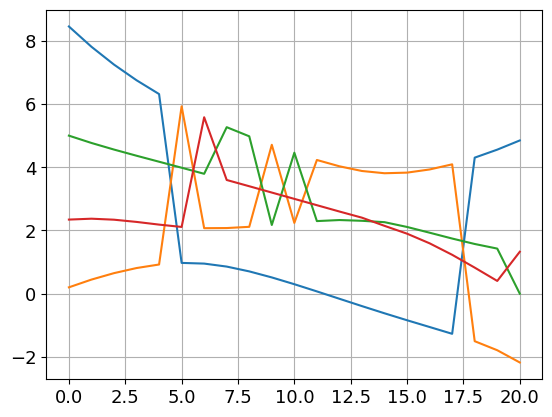

In [3]:
def eigenvalue_function(
    t: float,
) -> npt.NDArray[np.float_]:
    return np.array(
        [
            [1, 2 * t + 1, t**2, t**3],
            [2 * t + 1, 2 - t, t**2, 1 - t**3],
            [t**2, t**2, 3 - 2 * t, t**2],
            [t**3, 1 - t**3, t**2, 4 - 3 * t],
        ]
    )


tseq = np.arange(-1, 1.1, 0.1)
Aseq = np.array([eigenvalue_function(ti) for ti in tseq])

e, v = np.linalg.eig(Aseq)

fig, ax = plt.subplots()
ax.plot(e)
ax.grid()

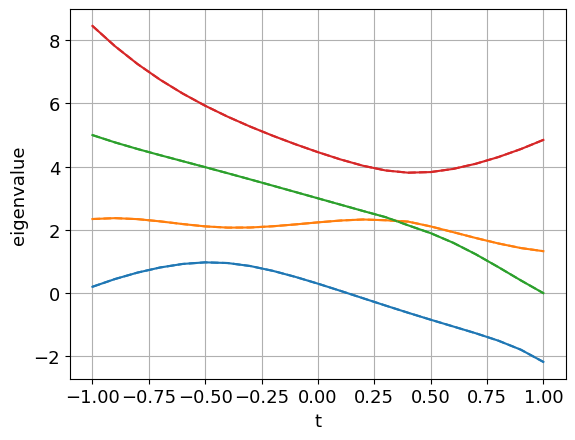

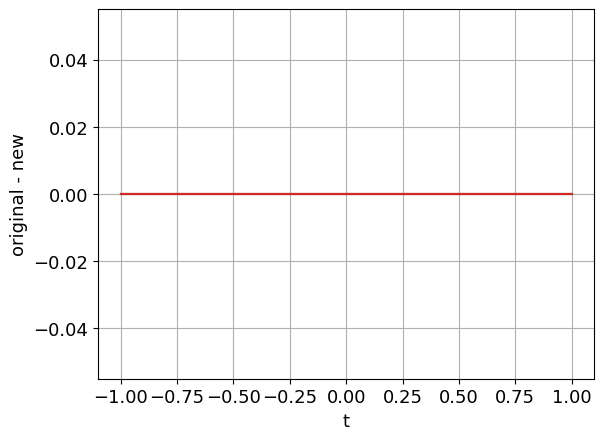

In [4]:
eo, vo = eigenshuffle_original(Aseq)
ei, vi = eigenshuffle_eig(Aseq)
fig, ax = plt.subplots()
lines = ax.plot(tseq, eo.real)
for i in range(ei.shape[-1]):
    ax.plot(tseq, ei.real[:, i], "--", color=lines[i].get_color())
ax.set_xlabel("t")
ax.set_ylabel("eigenvalue")
ax.grid()

fig, ax = plt.subplots()
ax.plot(tseq, (eo - ei).real)
ax.set_xlabel("t")
ax.set_ylabel("original - new")
ax.grid()

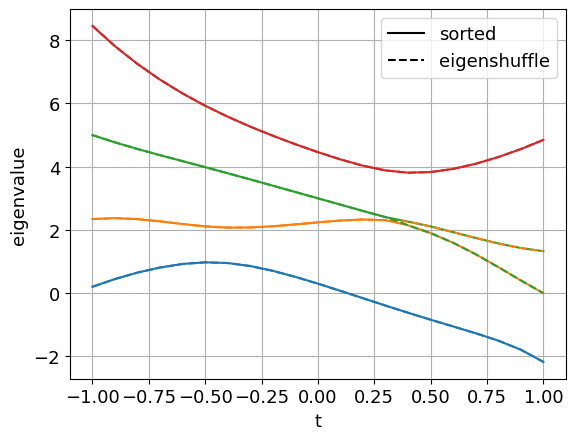

In [5]:
# sorting original eig result from low to high
v[np.argsort(e)]
e = np.sort(e)

fig, ax = plt.subplots()
lines = ax.plot(tseq, e)

for i in range(ei.shape[-1]):
    ax.plot(tseq, ei.real[:, i], "--", color=lines[i].get_color())

# for generating the legend
line1 = plt.Line2D([0, 1], [0, 1], linestyle="-", color="black")
line2 = plt.Line2D([0, 1], [0, 1], linestyle="--", color="black")

ax.set_xlabel("t")
ax.set_ylabel("eigenvalue")
ax.legend([line1, line2], ["sorted", "eigenshuffle"])
ax.grid()
